# 1. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import glob as glob
import cv2

all_data = np.array(glob.glob('./archive/clothes_dataset/*/*.jpg', recursive=True))

def check_cc(color, clothes):
    labels = np.zeros(11,)
    
    # color check
    if(color == 'black'):
        labels[0] = 1
        color_index = 0
    elif(color == 'blue'):
        labels[1] = 1
        color_index = 1
    elif(color == 'brown'):
        labels[2] = 1
        color_index = 2
    elif(color == 'green'):
        labels[3] = 1
        color_index = 3
    elif(color == 'red'):
        labels[4] = 1
        color_index = 4
    elif(color == 'white'):
        labels[5] = 1
        color_index = 5
        
    # clothes check
    if(clothes == 'dress'):
        labels[6] = 1
    elif(clothes == 'shirt'):
        labels[7] = 1
    elif(clothes == 'pants'):
        labels[8] = 1
    elif(clothes == 'shorts'):
        labels[9] = 1
    elif(clothes == 'shoes'):
        labels[10] = 1
        
    return labels, color_index

all_labels = np.empty((all_data.shape[0], 11))
all_color_labels = np.empty((all_data.shape[0], 1))

for i, data in enumerate(all_data):
    color_and_clothes = all_data[i].split('\\')[1].split('_')
    color = color_and_clothes[0]
    clothes = color_and_clothes[1]
    
    labels, color_index = check_cc(color, clothes)
    all_labels[i] = labels; all_color_labels[i] = color_index
    
all_labels = np.concatenate((all_labels, all_color_labels), axis = -1)

In [2]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(all_data, all_labels, shuffle = True, test_size = 0.3,
                                                   random_state = 99)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, shuffle = True, test_size = 0.3,
                                                 random_state = 99)

In [3]:
train_df = pd.DataFrame({'image':train_x, 'black':train_y[:, 0], 'blue':train_y[:, 1],
                        'brown':train_y[:, 2], 'green':train_y[:, 3], 'red':train_y[:, 4],
                        'white':train_y[:, 5], 'dress':train_y[:, 6], 'shirt':train_y[:, 7],
                        'pants':train_y[:, 8], 'shorts':train_y[:, 9], 'shoes':train_y[:, 10],
                        'color':train_y[:, 11]})

val_df = pd.DataFrame({'image':val_x, 'black':val_y[:, 0], 'blue':val_y[:, 1],
                        'brown':val_y[:, 2], 'green':val_y[:, 3], 'red':val_y[:, 4],
                        'white':val_y[:, 5], 'dress':val_y[:, 6], 'shirt':val_y[:, 7],
                        'pants':val_y[:, 8], 'shorts':val_y[:, 9], 'shoes':val_y[:, 10],
                        'color':val_y[:, 11]})

test_df = pd.DataFrame({'image':test_x, 'black':test_y[:, 0], 'blue':test_y[:, 1],
                        'brown':test_y[:, 2], 'green':test_y[:, 3], 'red':test_y[:, 4],
                        'white':test_y[:, 5], 'dress':test_y[:, 6], 'shirt':test_y[:, 7],
                        'pants':test_y[:, 8], 'shorts':test_y[:, 9], 'shoes':test_y[:, 10],
                        'color':test_y[:, 11]})

In [4]:
train_df.to_csv('./csv_data/nocolorinfo/train.csv')
val_df.to_csv('./csv_data/nocolorinfo/val.csv')
test_df.to_csv('./csv_data/nocolorinfo/test.csv')

In [5]:
train_df.to_csv('./csv_data/colorinfo/train_color.csv')
val_df.to_csv('./csv_data/colorinfo/val_color.csv')
test_df.to_csv('./csv_data/colorinfo/test_color.csv')

In [6]:
import pandas as pd

DATA_PATH = './csv_data/nocolorinfo/'

train_df = pd.read_csv(DATA_PATH + 'train.csv', index_col = 0)
val_df = pd.read_csv(DATA_PATH + 'val.csv', index_col = 0)
test_df = pd.read_csv(DATA_PATH + 'test.csv', index_col = 0)

train_df.head()

,image,black,blue,brown,green,red,white,dress,shirt,pants,shorts,shoes,color
0,./archive/clothes_dataset\green_shoes\f1f33bed...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
1,./archive/clothes_dataset\brown_pants\8a797ffb...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
2,./archive/clothes_dataset\white_dress\ef86bf5e...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,5.0
3,./archive/clothes_dataset\black_shoes\ff7f5589...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,./archive/clothes_dataset\blue_pants\b354ab537...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


# 2. 이미지 제너레이터 정의 및 모델 구성

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

def get_steps(num_samples, batch_size):
    if (num_samples % batch_size) > 0:
        return (num_samples // batch_size) + 1
    else:
        return num_samples // batch_size

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape = (112,112,3)))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(11, activation = 'sigmoid'))

model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['acc'])

# 3. 데이터 제너레이터 정의

In [9]:
batch_size = 32
class_col = ['black', 'blue', 'brown', 'green', 'red', 'white', 'dress', 'shirt', 'pants', 'shorts', 'shoes']

train_generator = train_datagen.flow_from_dataframe(dataframe = train_df, directory='', x_col = 'image', y_col = class_col,
                                                   target_size = (112, 112), color_mode = 'rgb', class_mode = 'other',
                                                   batch_size = batch_size, seed = 42)

val_generator = val_datagen.flow_from_dataframe(dataframe = val_df, directory='', x_col = 'image', y_col = class_col,
                                                   target_size = (112, 112), color_mode = 'rgb', class_mode = 'other',
                                                   batch_size = batch_size, shuffle = True)

Found 5578 validated image filenames.
Found 2391 validated image filenames.


# 4. 모델학습

In [10]:
model.fit(train_generator, steps_per_epoch = get_steps(len(train_df), batch_size),
         validation_data = val_generator, validation_steps = get_steps(len(val_df), batch_size),
         epochs = 10)

Epoch 1/10
175/175 [==============================] - 16s 86ms/step - loss: 0.5377 - acc: 0.2743 - val_loss: 0.3421 - val_acc: 0.5546
Epoch 2/10
175/175 [==============================] - 14s 83ms/step - loss: 0.2801 - acc: 0.4096 - val_loss: 0.2570 - val_acc: 0.3931
Epoch 3/10
175/175 [==============================] - 14s 82ms/step - loss: 0.2371 - acc: 0.4607 - val_loss: 0.2280 - val_acc: 0.4207
Epoch 4/10
175/175 [==============================] - 14s 83ms/step - loss: 0.2144 - acc: 0.5022 - val_loss: 0.2303 - val_acc: 0.4760
Epoch 5/10
175/175 [==============================] - 15s 88ms/step - loss: 0.1978 - acc: 0.5235 - val_loss: 0.1923 - val_acc: 0.5554
Epoch 6/10
175/175 [==============================] - 15s 85ms/step - loss: 0.1846 - acc: 0.5380 - val_loss: 0.2047 - val_acc: 0.6307
Epoch 7/10
175/175 [==============================] - 14s 82ms/step - loss: 0.1842 - acc: 0.5550 - val_loss: 0.1861 - val_acc: 0.5646
Epoch 8/10
175/175 [==============================] - 14s 82ms

# 5. 테스트 데이터 준비

In [11]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df, 
    directory=None,
    x_col = 'image',
    y_col = None,
    target_size = (112, 112),
    color_mode='rgb',
    class_mode=None,
    batch_size=batch_size,
    shuffle = False
)

Found 3416 validated image filenames.


# 6. 예측

In [12]:
preds = model.predict(test_generator,
                      steps = get_steps(len(test_df), batch_size),
                      verbose = 1)

107/107 [==============================] - 6s 57ms/step


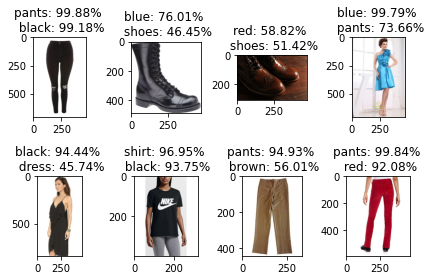

In [13]:
import matplotlib.pyplot as plt
import cv2

do_preds = preds[:8]

for i, pred in enumerate(do_preds):
    plt.subplot(2, 4, i+1)
    prob = zip(class_col, list(pred))
    prob = sorted(list(prob), key = lambda z: z[1], reverse = True)[:2]
    
    image = cv2.imread(test_df['image'][i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    plt.title(f'{prob[0][0]}: {round(prob[0][1] * 100, 2)}% \n {prob[1][0]}: {round(prob[1][1] * 100, 2)}%')
    
plt.tight_layout()
plt.show()